In [1]:
import sys, os
sys.path.insert(0, '..')

In [2]:
import graph_tool.all as gt
import graph_embeddings
from models.crosswalk import Crosswalk
from utils.score import statistical_parity
import faiss
import residual2vec as rv
import numpy as np
import pandas as pd
from scipy import sparse
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

from sklearn.neighbors import kneighbors_graph
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder



Bad key "text.kerning_factor" on line 4 in
/home/ashutosh/miniconda3/envs/study/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
2022-08-10 13:26:32.910007: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2022-08-10 13:26:32.933164: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2304000000 Hz
2022-08-10 13:26:32.934023: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x556fe0849a50 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-08-10 13:26:32.934037: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-08-10 13:26:32

In [3]:

DATA_FILE = '../data/polbooks.gml'
G = nx.read_gml(DATA_FILE)
G = nx.relabel.convert_node_labels_to_integers(G, first_label=0, ordering='default')

nodes = G.nodes(data=True)
labels, group_ids = np.unique([n[1]['value'] for n in nodes], return_inverse=True)

A = nx.adjacency_matrix(G).asfptype()
deg = np.array(A.sum(axis=1)).reshape(-1)
G = nx.from_scipy_sparse_matrix(A)

models = {}
window_length = 5
num_walks = 10
dim = 128

models["unbiased"] = graph_embeddings.DeepWalk(window_length=window_length, num_walks=num_walks, restart_prob=0)

models["degree-unbiased"] = rv.residual2vec_sgd(
    noise_sampler=rv.ConfigModelNodeSampler(),
    window_length=window_length,
    num_walks=num_walks,
    cuda=True,
    walk_length=80
)

models["group-unbiased"] = rv.residual2vec_sgd(
    noise_sampler=rv.SBMNodeSampler(
        group_membership=group_ids, window_length=window_length,
    ),
    window_length=window_length,
    num_walks=num_walks,
    cuda=True,
    walk_length=80,
)

models["fairwalk"] = graph_embeddings.Fairwalk(window_length=window_length, num_walks=num_walks)
models["fairwalk-group-unbiased"] = graph_embeddings.Fairwalk(
    window_length=window_length, num_walks=num_walks, group_membership=group_ids
)
models['GCN'] = graph_embeddings.GCN()
models["gcn-doubleK"] = graph_embeddings.GCN(num_default_features=dim * 2)
models["graphsage"] = graph_embeddings.GraphSage()
models["graphsage-doubleK"] = graph_embeddings.GraphSage(num_default_features=dim * 2)
models["gat"] = graph_embeddings.GAT(layer_sizes=[64, 256])
models["gat-doubleK"] = graph_embeddings.GAT(num_default_features=dim * 2)

models['crosswalk'] = Crosswalk(group_membership=group_ids, window_length=window_length, num_walks=num_walks)

In [4]:
A[0:].todense(), A.shape

(matrix([[0., 1., 1., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 1.],
         [0., 0., 0., ..., 0., 1., 0.]]),
 (105, 105))

In [5]:
embs = {}

for k, model in tqdm(models.items()):
    print(model.__class__.__name__)
    sys.stdout = open(os.devnull, 'w')
    emb = model.fit(A).transform(dim=dim)
    sys.stdout = sys.__stdout__
    embs[k] = emb

  8%|██████████▏                                                                                                               | 1/12 [00:00<00:01,  7.41it/s]

DeepWalk
residual2vec_sgd



  0%|                                                                                                                      | 0/329 [00:00<?, ?it/s, loss=1.06]


 30%|████████████████████████████████▌                                                                          | 100/329 [00:00<00:00, 342.84it/s, loss=1.08]


 61%|████████████████████████████████████████████████████████████████▍                                         | 200/329 [00:00<00:00, 371.98it/s, loss=0.961]


  0%|                                                                                                                      | 0/329 [00:00<?, ?it/s, loss=1.35]

residual2vec_sgd



 30%|████████████████████████████████▌                                                                          | 100/329 [00:00<00:00, 347.31it/s, loss=1.25]


 61%|█████████████████████████████████████████████████████████████████                                          | 200/329 [00:00<00:00, 375.92it/s, loss=1.25]


 25%|██████████████████████████████▌                                                                                           | 3/12 [00:05<00:17,  1.96s/it]

Fairwalk


 42%|██████████████████████████████████████████████████▊                                                                       | 5/12 [00:06<00:06,  1.13it/s]

Fairwalk
GCN
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
  ...
    to  
  ['...']
  ...
    to  
  ['...']


 50%|█████████████████████████████████████████████████████████████                                                             | 6/12 [00:12<00:17,  2.88s/it]

GCN
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
  ...
    to  
  ['...']
  ...
    to  
  ['...']


 58%|███████████████████████████████████████████████████████████████████████▏                                                  | 7/12 [00:20<00:21,  4.29s/it]

GraphSage
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the

2022-08-10 13:26:55.619275: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
2022-08-10 13:26:56.275496: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
2022-08-10 13:26:56.936266: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
2022-08-10 13:26:57.556429: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
2022-08-10 13:26:58.207870: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
2022-08-10 13:26:58.768380: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error o

GraphSage
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the

2022-08-10 13:27:00.721708: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
2022-08-10 13:27:01.361236: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
2022-08-10 13:27:02.069461: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
2022-08-10 13:27:02.723911: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
2022-08-10 13:27:03.408316: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error occurred when finalizing GeneratorDataset iterator: Cancelled: Operation was cancelled
2022-08-10 13:27:03.967849: W tensorflow/core/kernels/data/generator_dataset_op.cc:103] Error o

GAT
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
  ...
    to  
  ['...']
  ...
    to  
  ['...']


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 10/12 [00:41<00:13,  6.69s/it]

GAT
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: No module named 'tensorflow_core.estimator'
  ...
    to  
  ['...']
  ...
    to  
  ['...']


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 11/12 [00:53<00:08,  8.40s/it]

Crosswalk


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:56<00:00,  4.71s/it]


class score:  unbiased 0.1495141208803182
class score:  degree-unbiased 0.15042825973308227
class score:  group-unbiased 0.1348024118897452
class score:  fairwalk 0.16409625627392552
class score:  fairwalk-group-unbiased 0.14417447492220856
class score:  GCN 0.13494850406269307
class score:  gcn-doubleK 0.13857692855052092
class score:  graphsage 0.0922196545241949
class score:  graphsage-doubleK 0.08932393397416429
class score:  gat 0.15987955007528276
class score:  gat-doubleK 0.2198035198910634
class score:  crosswalk 0.07250474593727811


In [6]:

def reconstruct_graph(emb, n, m):
    # choose top m edges to reconstruct the graph
    S = emb @ emb.T
    S = np.triu(S, k=1)
    r, c, v = sparse.find(S)
    idx = np.argsort(-v)[:m]
    r, c, v = r[idx], c[idx], v[idx]
    B = sparse.csr_matrix((v, (r, c)), shape=(n, n))
    B = B + B.T
    B.data = B.data * 0 + 1
    return nx.from_scipy_sparse_matrix(B + B.T)



In [7]:
n_edges = int(A.sum() / 2)
n_nodes = A.shape[0]
rgraphs = {}
for k, emb in embs.items():
    rgraphs[k] = reconstruct_graph(emb, n_nodes, n_edges)

In [8]:
scores = {}
for k, graph in rgraphs.items():
    scores[k] = statistical_parity(graph, group_ids)
    print("class score: ", k, scores[k])

[Text(0,0,'unbiased'),
 Text(0,0,'degree-unbiased'),
 Text(0,0,'group-unbiased'),
 Text(0,0,'fairwalk'),
 Text(0,0,'fairwalk-group-unbiased'),
 Text(0,0,'GCN'),
 Text(0,0,'gcn-doubleK'),
 Text(0,0,'graphsage'),
 Text(0,0,'graphsage-doubleK'),
 Text(0,0,'gat'),
 Text(0,0,'gat-doubleK'),
 Text(0,0,'crosswalk')]

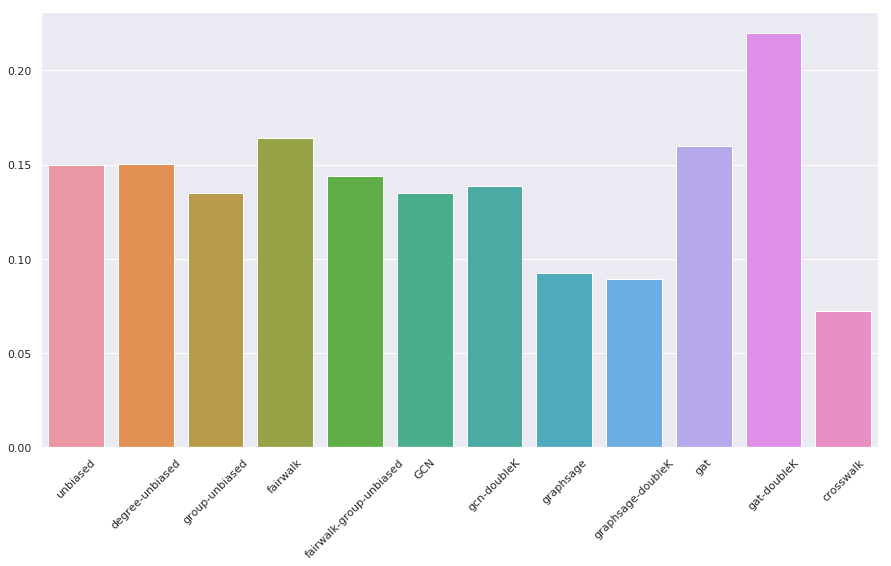

In [9]:
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(scores.keys()), y=list(scores.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)

In [10]:
import pickle as pkl
pkl.dump(rgraphs, open('/tmp/rgraphs.pkl', 'wb'))
pkl.dump(group_ids, open('/tmp/group_ids.pkl', 'wb'))
pkl.dump(embs, open('/tmp/embs.pkl', 'wb'))


In [11]:
# check shapes of different properties of the r2v
model = models['degree-unbiased']

In [12]:
type(model)

residual2vec.residual2vec_sgd.residual2vec_sgd

In [13]:
model.in_vec.shape, model.out_vec.shape

((105, 128), (105, 128))